In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2
import os
import time

In [135]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    x_center, y_center, width, height = bbox*416
    #x_min,y_min,x_max,y_max=bbox
    x_min = int(x_center-(width//2))
    y_min = int(y_center-(height//2))
    x_max = int(x_center+(width//2))
    y_max = int(y_center+(height//2))
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    #class_name = class_idx_to_name[class_id]
    #((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    #cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    #cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox)
    plt.imshow(img)

In [6]:
image_feature_description = {
    'bboxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [7]:
np.random.random()

0.7005915934442601

## USING IMGAUG

In [8]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline
#ia.seed(0)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2
import os

In [9]:
image_feature_description = {
    'bboxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'num_real_boxes':tf.io.FixedLenFeature([], tf.int64),
}

In [10]:
def get_iou_matrix_tf(box_arr1, box_arr2):
    
    box_arr1 = box_arr1 -tf.tile(box_arr1[:,:2],[1,2])
    #print(box_arr1)
    x11, y11, x12, y12 = tf.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(box_arr2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    yA = tf.maximum(y11, tf.transpose(y21))
    xB = tf.minimum(x12, tf.transpose(x22))
    yB = tf.minimum(y12, tf.transpose(y22))
    interArea = tf.maximum((xB - xA + 1e-9), 0) * tf.maximum((yB - yA + 1e-9), 0)
    boxAArea = (x12 - x11 + 1e-9) * (y12 - y11 + 1e-9)
    boxBArea = (x22 - x21 + 1e-9) * (y22 - y21 + 1e-9)
    iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)
    return iou,tf.argmax(iou,axis=1)#[:,tf.newaxis]


def fill_yolo_output(boxes,grid_size,num_anchors,which_anchor_box,which_anchor_box_index):
    #print(boxes.shape)
    #noobj_mask = tf.ones((1,grid_size*grid_size*num_anchors))
    #print(noobj_mask.shape)
    
    x_min,y_min,x_max,y_max =tf.split(boxes,4,axis=1)

    #Transforma las coordenadas de (xmin,ymin,xmax,ymax) --> (xcenter,ycenter,width,height)
    width = x_max-x_min
    height = y_max-y_min
    x_global =x_min + tf.math.divide(x_max - x_min,2)
    y_global =y_min + tf.math.divide(y_max - y_min,2)
    
    
    x_min_anchor,y_min_anchor,x_max_anchor,y_max_anchor =tf.split(which_anchor_box,4,axis=1)
    
    width_anchor = x_max_anchor-x_min_anchor
    height_anchor = y_max_anchor-y_min_anchor
    x_global_anchor =x_min_anchor + tf.math.divide(x_max_anchor - x_min_anchor,2)
    y_global_anchor =y_min_anchor + tf.math.divide(y_max_anchor - y_min_anchor,2)   

    
    #print("el x original",x_global)
    #print("el y original",y_global)
    #print("el w original",width)
    #print("el h original",height)
    
    #porción de la imagen que hay en cada celda
    pixel_per_grid = tf.math.divide(1.,grid_size)
    #print(pixel_per_grid)
    
    #Obtenemos la coordenada de la celda donde están los boundingboxes
    offset_grid_x = x_global//pixel_per_grid
    offset_grid_y = y_global//pixel_per_grid
    
    #Obtenemos el el centro locacon referencia  al celda encontrada previamente
    x_local =tf.math.floormod(x_global,pixel_per_grid)
    y_local =tf.math.floormod(y_global,pixel_per_grid)
    #print(x_local,y_local)
    
    #Valores tx e ty del groudtruth
    tx = tf.math.log(x_local + 1e-07/(1-x_local))
    ty = tf.math.log(y_local+1e-07/(1-y_local))
    tw = tf.math.log(tf.math.divide(width+1e-07,width_anchor))
    th = tf.math.log(tf.math.divide(height+1e-07,height_anchor))
    tobj_mask = tf.ones_like(tx)
    tobj = tf.concat([tobj_mask,tobj_mask],axis=0)
    
    #tnoobj = tf.zeros_like(tx)    
    #tobj = tf.ones((grid_size*grid_size*num_anchors,1))
    #tnoobj = tf.zeros((grid_size*grid_size*num_anchors,1))
    #print("Lo que la red debe predecir",tx.numpy(),ty.numpy(),tw.numpy(),th.numpy())
    #x_global = (offset_grid_x * pixel_per_grid) + tf.math.sigmoid(tx)
    #y_global = (offset_grid_y * pixel_per_grid) + tf.math.sigmoid(ty)
    #w = width_anchor*tf.math.exp(tw)
    #h = height_anchor*tf.math.exp(th)
    #print("obtnemos el x_real",x_global)
    #print("obtenemos el y_real",y_global)
    #print("obtenemos el w real",w)
    #print("obtenemos el h real",h)
    
    #anchor_boxes_per_output = num_anchors//2

    #Residuo indica cual de los 3 anchor boxes de la coordenada es la que llevara el 1
    #Coord representa la coordenada del grid
    
    residuo = tf.math.floormod(which_anchor_box_index,num_anchors)[:,tf.newaxis]
    coord = tf.cast(num_anchors*(offset_grid_y*grid_size + offset_grid_x),dtype=tf.int64)
    
    coord_objectness = tf.cast(2*(offset_grid_y*grid_size + offset_grid_x),dtype=tf.int64)
    coord_objectness2 = coord_objectness+1
    coord_objectess_global = tf.concat([coord_objectness,coord_objectness2],axis=0)
    
    output_position = residuo+coord
    print("tipo de aoutput_positivon",output_position)
    
    print(output_position)
    
    dense_shape = grid_size*grid_size*num_anchors
    print(dense_shape)
    tx_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tx[:,0], dense_shape=[dense_shape]))
    ty_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=ty[:,0], dense_shape=[dense_shape]))
    tw_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tw[:,0], dense_shape=[dense_shape]))
    th_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=th[:,0], dense_shape=[dense_shape]))
    obj_mask = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tobj_mask[:,0], dense_shape=[dense_shape]))
    objectness_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=coord_objectess_global, values=tobj[:,0], dense_shape=[dense_shape]))
    #noobj_mask = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tnoobj[:,0], dense_shape=[dense_shape]))
    #obj_mask =tx_vector=ty_vector=tw_vector=th_vector = tf.zeros((1,grid_size*grid_size*num_anchors))
    
    tx_vector_dense = tf.sparse.to_dense(tx_vector, default_value=0, validate_indices=False, name="Dense_tx")
    ty_vector_dense = tf.sparse.to_dense(ty_vector, default_value=0, validate_indices=False, name="Dense_ty")
    tw_vector_dense = tf.sparse.to_dense(tw_vector, default_value=0, validate_indices=False, name="Dense_tw")
    th_vector_dense = tf.sparse.to_dense(th_vector, default_value=0, validate_indices=False, name="Dense_th")
    obj_mask_dense =  tf.sparse.to_dense(obj_mask, default_value=0, validate_indices=False, name="Dense_obj")
    #noobj_mask_dense = 1-obj_mask_dense
    objectness_vector_dense =  tf.sparse.to_dense(objectness_vector, default_value=0, validate_indices=False)
    
    #noobj_mask_dense= tf.sparse.to_dense(noobj_mask, default_value=1, validate_indices=False, name="Dense_noobj")
    ##print(tx_vector.to_dense)
    #print(tf.sparse.to_dense(tx_vector, default_value=0, validate_indices=True, name=None)
    #tx_vector=tx_vector[[3,2],]
    #tx_vector[output_position[:,0]] = tx
    #print("coordenada de la salida:",output_position)
    
    #return ((tx_vector_dense,ty_vector_dense,obj_mask_dense),(tw_vector_dense,th_vector_dense,obj_mask_dense),(objectness),(objectness))
    
    return tx_vector_dense,ty_vector_dense,tw_vector_dense,th_vector_dense,obj_mask_dense,objectness_vector_dense

def build_targets(image,image_bboxes,num_real_boxes,anchor_boxes):
    
    images_bboxes_original = image_bboxes
    #Obtenemos los boduing boxes que son reales
    image_bboxes = image_bboxes[:num_real_boxes,:]
    #print("Bouding boxes de la imagen",image_bboxes)
    #Obteneos  la matriz de IoU , y el índice del anchor box que dió mejor resultado
    
    #Nprmalizamos con respecto al tamaño de la imagen y obtenemos la Iou con los anchor boxes
    image_bboxes = tf.math.divide(image_bboxes,416)
    iou_matrix,which_anchor_box_index = get_iou_matrix_tf(image_bboxes,anchor_boxes)
    
    print(which_anchor_box_index)

    anchor_boxes_per_output = len(anchor_boxes)//2
    #Indices de los bouding boxes que irian en cada salida, index_best_ yolo nos dice que bouding boxes de la imagen van a la salida YOLO1,
    #porque su mejor IoU fue con los len(anchor_boxes)//2 anchor boxes mas grandes
    index_best_yolo1 = tf.where(which_anchor_box_index>=anchor_boxes_per_output)[:,0]
    index_best_yolo2 = tf.where(which_anchor_box_index<anchor_boxes_per_output)[:,0]
    index_best_anchor_yolo1 = tf.gather(which_anchor_box_index,index_best_yolo1,axis=0)
    index_best_anchor_yolo2 = tf.gather(which_anchor_box_index,index_best_yolo2,axis=0)
    
    print(index_best_yolo1)
    print(index_best_anchor_yolo1)

    print(index_best_yolo2)
    print(index_best_anchor_yolo2)

    
    best_bboxes_yolo1 = tf.gather(image_bboxes,index_best_yolo1,axis =0)
    best_anchors_yolo1 = tf.gather(anchor_boxes,index_best_anchor_yolo1, axis =0) #LOs dos anchor boxes grandes corrsponden a YOLO1
    best_bboxes_yolo2 = tf.gather(image_bboxes,index_best_yolo2,axis =0)
    best_anchors_yolo2 = tf.gather(anchor_boxes,index_best_anchor_yolo2, axis =0) #Los dos anchor boxes pequeños corresponden a YOLO2
    
    
    if best_anchors_yolo1.shape[0] !=0:
        tx_vector_yolo1,ty_vector_yolo1,tw_vector_yolo1,th_vector_yolo1,obj_mask_yolo1,obj_vector_yolo1= fill_yolo_output(best_bboxes_yolo1,13,anchor_boxes_per_output,best_anchors_yolo1,index_best_anchor_yolo1)
    else:
        tx_vector_yolo1=ty_vector_yolo1=tw_vector_yolo1=th_vector_yolo1=obj_mask_yolo1= obj_vector_yolo1=tf.zeros((1,grid_size*grid_size*num_anchors))
        #noobj_mask_yolo1 = tf.ones((1,13*13*num_anchors))
    
    if best_anchors_yolo2.shape[0] != 0:
        tx_vector_yolo2,ty_vector_yolo2,tw_vector_yolo2,th_vector_yolo2,obj_mask_yolo2,obj_vector_yolo2 = fill_yolo_output(best_bboxes_yolo2,26,anchor_boxes_per_output,best_anchors_yolo2,index_best_anchor_yolo2)
    else:
        tx_vector_yolo2=ty_vector_yolo2=tw_vector_yolo2=th_vector_yolo2=obj_mask_yolo2 = obj_vector_yolo2=tf.zeros((1,grid_size*grid_size*num_anchors))
        #noobj_mask_yolo2 = tf.ones((1,26*26*num_anchors))
        
    tx_vector = tf.concat([tx_vector_yolo1,tx_vector_yolo2],axis=0)[:,tf.newaxis]
    ty_vector = tf.concat([ty_vector_yolo1,ty_vector_yolo2],axis=0)[:,tf.newaxis]
    tw_vector = tf.concat([tw_vector_yolo1,tw_vector_yolo2],axis=0)[:,tf.newaxis]
    th_vector = tf.concat([th_vector_yolo1,th_vector_yolo2],axis=0)[:,tf.newaxis]
    obj_mask = tf.concat([obj_mask_yolo1,obj_mask_yolo2],axis=0)[:,tf.newaxis]
    #noobj_mask = tf.concat([noobj_mask_yolo1,noobj_mask_yolo2],axis=0)[:,tf.newaxis]
    obj_vector = tf.concat([obj_vector_yolo1,obj_vector_yolo2],axis=0)[:,tf.newaxis]
    
    #output = tf.concat([tx_vector,ty_vector,tw_vector,th_vector,obj_mask,noobj_mask,obj_vector],axis=1)
    #images_bboxes_original
    #return image,output
    #Vamos a regresar obj mask que es 1 cuando hay objeto en grid y el anchor box especifico
    return tf.cast(image,tf.float32)/255,
            (tf.concat([tx_vector,ty_vector,obj_mask],axis=1),
                 tf.concat([tw_vector,th_vector,obj_mask],axis=1),
                 (obj_mask),
                 (obj_mask))

def imgaug_data_augmentation(image,bboxes,num_real_boxes):
    im_shape = image.shape
    bbs = BoundingBoxesOnImage.from_xyxy_array(bboxes*416, shape=(416,416))
    
    policy = np.random.randint(5)
    
    #policy = 2
    if policy == 0:
        
        p = np.random.random()
        if p<=0.6:
            aug = iaa.TranslateX(px=(-60, 60),cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clix_coord = tf.math.floormod(casilla_con_objecto,13)p_out_of_image()
    
        p = np.random.random()
        if p<=0.8:
            aug = iaa.HistogramEqualization()
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
    elif policy==1:
        
        p=np.random.random()
        if p<=0.2:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
        
        p=np.random.random()
        if p<=0.8:
            square_size = np.random.randint(48)
            aug = iaa.Cutout(nb_iterations=1, size=square_size/416, squared=True)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
    elif policy==2:
        p=np.random.random()
        if p<=1:
            aug = iaa.ShearY(shear=(int(-0.06*416), int(0.06*416)), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
        p=np.random.random()
        if p<=0.6:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
            
    elif policy==3:
        p=np.random.random()
        if p<=0.6:    
            aug = iaa.Rotate(rotate=(-30, 30), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs_aug.remove_out_of_image().clip_out_of_image()
        
        p=np.random.random()
        if p<=1:
            aug = iaa.MultiplySaturation((0.54, 1.54))
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
    bbs.remove_out_of_image()
    
    return image,np.clip(bbs.to_xyxy_array(np.float32),1,415),num_real_boxes
    
    
def preprocessing(example_proto):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_jpeg(image_features['image_raw'],channels = 3)
    image = tf.cast(tf.image.resize(image,size=(416,416)), tf.uint8)
    bboxes =  tf.io.parse_tensor(image_features['bboxes'], out_type=tf.float32)
    
    num_real_boxes = image_features['num_real_boxes']
    return image,bboxes,num_real_boxes

def preprocessing_validation_set(example_proto):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_jpeg(image_features['image_raw'],channels = 3)
    image = tf.cast(tf.image.resize(image,size=(416,416)), tf.uint8)
    bboxes =  tf.io.parse_tensor(image_features['bboxes'], out_type=tf.float32)
    bboxes = tf.clip_by_value(bboxes*416,1,415)
    
    num_real_boxes = image_features['num_real_boxes']
    return image,bboxes,tf.cast(num_real_boxes,tf.int64)
    
@tf.function(input_signature=[tf.TensorSpec((416,416,3), tf.uint8),tf.TensorSpec((None,4), tf.float32),tf.TensorSpec((), tf.int64)]) 
def tf_numpy_albumentations_real(image,bboxes,num_real_boxes):
    
    boxes_shape = bboxes.shape
    im_shape = image.shape

    image,bboxes,num_real_boxes = tf.numpy_function(imgaug_data_augmentation,[image,bboxes,num_real_boxes],Tout =[tf.uint8,tf.float32,tf.int64])
 
    image.set_shape(im_shape)
    bboxes.set_shape(boxes_shape)
    print("Imagen data type",image.dtype)
    print("Bboxes data type",bboxes.dtype)
    print("num_real_boxes",num_real_boxes.dtype)

    return image,bboxes,num_real_boxes

In [12]:
root_path = "/tf/home/sergio/Tesis"

In [212]:
#USANDO TF.IMAGE MODULE
anchors =tf.constant(np.array([[0,0,0.02078,0.049],[0,0,0.0426,0.128],[0,0,0.08523,0.19356],[0,0,0.1506,0.4163],[0,0,0.27835,0.58651],[0,0,0.5632,0.78614]]),dtype=tf.float32)
os.chdir(root_path+"/pedestrian_dataset_train_tfr")
filenames = os. listdir()
raw_image_dataset = tf.data.TFRecordDataset(filenames)

train_dataset = raw_image_dataset.map(preprocessing_validation_set,num_parallel_calls=8)
#train_dataset = train_dataset.map(tf_numpy_albumentations_real,num_parallel_calls=8)
train_dataset = train_dataset.map(lambda x,y,z:build_targets(x,y,z,anchors),num_parallel_calls=8)
#train_dataset = train_dataset.batch(8)

Tensor("ArgMax:0", dtype=int64)
Tensor("strided_slice_2:0", shape=(None,), dtype=int64)
Tensor("GatherV2:0", dtype=int64)
Tensor("strided_slice_3:0", shape=(None,), dtype=int64)
Tensor("GatherV2_1:0", dtype=int64)
tipo de aoutput_positivon Tensor("add_18:0", dtype=int64)
Tensor("add_18:0", dtype=int64)
507
tipo de aoutput_positivon Tensor("add_30:0", dtype=int64)
Tensor("add_30:0", dtype=int64)
2028


In [213]:
import time

for index,i in enumerate(train_dataset.batch(8)):
    if index==1:
        break

In [214]:
num_image = 1

image = i[0][num_image]
conv_raw_dxdy_aux = i[1][0][num_image][:507,:2]
conv_raw_dwdh_aux = i[1][1][num_image][:507,:2]
t_obj =i[1][2][num_image][:507,0]

In [349]:
conv_raw_dxdy = tf.reshape(conv_raw_dxdy_aux, (batch_size, output_size, output_size, 3, 2))
conv_raw_dwdh = tf.reshape(conv_raw_dwdh_aux, (batch_size, output_size, output_size, 3, 2))
conv_raw_conf = tf.reshape(t_obj, (batch_size, output_size, output_size, 3, 1))

pred_conf = conv_raw_conf

anchors_predict =[[0.02078,0.049],[0.0426,0.128],[0.08523,0.19356],[0.1506,0.4163],[0.27835,0.58651],[0.5632,0.78614]]

output_size = 13
batch_size=1
STRIDES =[1/13]
ANCHORS =anchors_predict[3:]
xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
xy_grid = tf.expand_dims(tf.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
xy_grid = tf.tile(tf.expand_dims(xy_grid, axis=0), [batch_size, 1, 1, 3, 1])
xy_grid = tf.cast(xy_grid, tf.float32)
pred_xy = tf.reshape(tf.sigmoid(conv_raw_dxdy), (-1, 2)) + tf.reshape(xy_grid, (-1, 2))* STRIDES 
pred_xy = tf.reshape(pred_xy, (batch_size, output_size, output_size, 3, 2))

pred_wh = tf.exp(conv_raw_dwdh)*ANCHORS
pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

pred_conf = tf.reshape(pred_conf, (batch_size, -1,1))
pred_xywh = tf.reshape(pred_xywh, (batch_size, -1,4))

In [350]:
array([[238],
       [306],
       [327]])>

SyntaxError: invalid syntax (<ipython-input-350-d09b86cfefe0>, line 3)

In [351]:
casilla_con_objecto = tf.where(t_obj!=0)

In [352]:
x_coord = (tf.math.floormod(casilla_con_objecto,39)//3)/32
y_coord = tf.math.floordiv(casilla_con_objecto,39)/32

In [353]:
print(x_coord,y_coord)

tf.Tensor(
[[0.03125]
 [0.34375]
 [0.15625]], shape=(3, 1), dtype=float64) tf.Tensor(
[[0.1875 ]
 [0.21875]
 [0.25   ]], shape=(3, 1), dtype=float64)


In [354]:
t_centroids = tf.gather(conv_raw_dxdy_aux,tf.where(t_obj!=0)[:,0])

In [355]:
tf.sigmoid(t_centroids)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.05987328, 0.05141435],
       [0.04521304, 0.00503424],
       [0.02726132, 0.04682246]], dtype=float32)>

In [356]:
t_centroids = tf.gather(conv_raw_dxdy_aux,tf.where(t_obj!=0),axis=1)[0]

In [357]:
conv_raw_dxdy_aux

<tf.Tensor: shape=(507, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>

In [358]:
t_centroids

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.]], dtype=float32)>

In [359]:
bboxes = tf.gather(pred_xywh,tf.where(pred_conf!=0)[:,1],axis=1)[0]

In [360]:
bboxes

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.13679636, 0.51295286, 0.23334385, 0.6584274 ],
       [0.8913669 , 0.5434958 , 0.16757825, 0.6776527 ],
       [0.4118767 , 0.6622071 , 0.24028134, 0.3938029 ]], dtype=float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


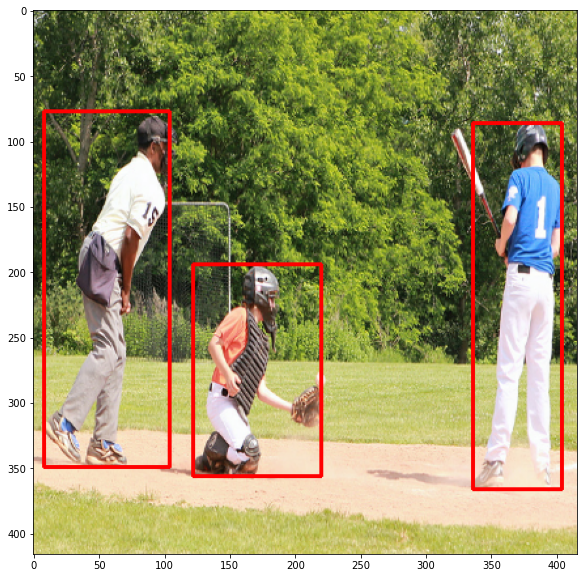

In [361]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

visualize(image.numpy(),bboxes.numpy())

In [362]:
anchor_boxes1 = [[0.1506,0.4163],[0.27835,0.58651],[0.5632,0.78614]]
anchor_boxes2 = [[0.02078,0.049],[0.0426,0.128],[0.08523,0.19356]]

num_anchors = len(anchor_boxes1)
num_classes = 1
training = False

final_conv_length = 5

conf_thresh = 0.5
grid_size = 13
strides = 1./13
#Anchor boxes en forma matricial de tamaño (grid_size*grid_size*anchors,2)
anchors_matrix =tf.cast(tf.tile(anchor_boxes1,[grid_size*grid_size,1]),dtype=tf.float32)
#print(self.anchors_matrix)
x = tf.range(grid_size, dtype=tf.float32)
y = tf.range(grid_size, dtype=tf.float32)
x_offset, y_offset = tf.meshgrid(x, y)
x_offset = tf.reshape(x_offset, (-1, 1))
y_offset = tf.reshape(y_offset, (-1, 1))
x_y_offset = tf.concat([x_offset, y_offset], axis=-1)
x_y_offset = tf.tile(x_y_offset, [1, num_anchors])
x_y_offset = tf.reshape(x_y_offset, [1, -1, 2])     
#x_y_offset es de tamaño (None,grid_size*grid_size*num_anchors,2) y asi ya es invariante del tamaño del grid.

#Se redimensiona la entrada para tener dimensiones (Batch_size,grid_size*grid_size*anchors,()

box_xy,box_wh,objectness =conv_raw_dxdy_aux,conv_raw_dwdh_aux,t_obj
box_xy = tf.sigmoid(box_xy)
box_xy = (box_xy) + x_y_offset*strides #Se encontra la coordenada (x,y) global del bouding box
box_wh = tf.exp(box_wh) * anchors_matrix #Se encuenta el ancho (eje X) y alto (eje Y) para cada bouding box
box_xy_wh = tf.concat([box_xy[0,:,:],box_wh],axis=1)

#objectness = tf.sigmoid(objectness) # Se encuentra la probabilidad de cada bouding box de que sea una persona

In [363]:
box_xy_wh

<tf.Tensor: shape=(507, 4), dtype=float32, numpy=
array([[0.5     , 0.5     , 0.1506  , 0.4163  ],
       [0.5     , 0.5     , 0.27835 , 0.58651 ],
       [0.5     , 0.5     , 0.5632  , 0.78614 ],
       ...,
       [1.423077, 1.423077, 0.1506  , 0.4163  ],
       [1.423077, 1.423077, 0.27835 , 0.58651 ],
       [1.423077, 1.423077, 0.5632  , 0.78614 ]], dtype=float32)>

In [364]:
tf.where(objectness!=0)

<tf.Tensor: shape=(3, 1), dtype=int64, numpy=
array([[238],
       [306],
       [327]])>

In [365]:
bboxes = tf.gather(box_xy_wh,tf.where(objectness!=0),axis=0)[:,0,:]

In [366]:
bboxes

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.13679636, 0.51295286, 0.23334385, 0.6584274 ],
       [0.8913669 , 0.5434958 , 0.16757825, 0.6776527 ],
       [0.4118767 , 0.6622071 , 0.24028134, 0.3938029 ]], dtype=float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


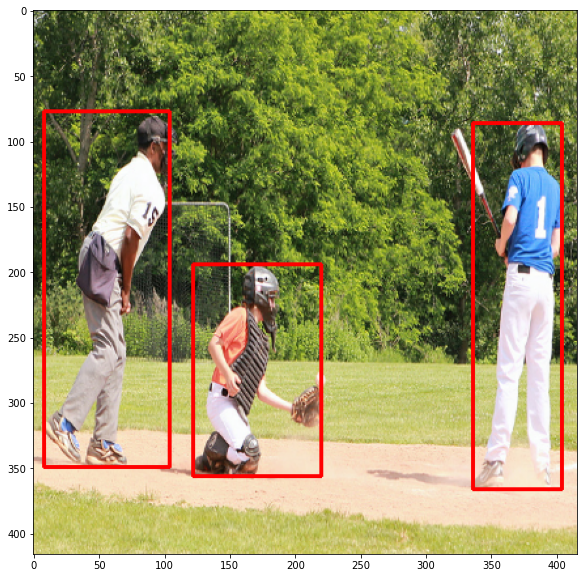

In [367]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

visualize(image.numpy(),bboxes.numpy())

In [320]:
x_y_offset

<tf.Tensor: shape=(1, 1014, 2), dtype=float32, numpy=
array([[[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [12., 12.],
        [12., 12.],
        [12., 12.]]], dtype=float32)>

In [37]:
image_1 = image[1,:].numpy()

In [75]:
print(images_bboxes)
print((199-164)/2+(164))
print((238-171)/2+(171))

tf.Tensor(
[[[194.00452  130.17656  274.22452  277.47037 ]
  [164.93195  171.3831   199.91245  238.9372  ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]
  [168.66846  166.40001  208.       221.54948 ]]

 [[160.93376   19.138659 23

In [78]:

#Obtenemos la coordenada de la celda donde están los boundingboxes
offset_grid_x = 181.5//32
offset_grid_y = 204.5//32

print(offset_grid_x)
print(offset_grid_y)

print(6*13+7)

#Obtenemos el el centro locacon referencia  al celda encontrada previamente
x_local =tf.math.floormod(181,32)
y_local =tf.math.floormod(204.5,32)

5.0
6.0
85


In [77]:
boxes1_ = i[1][1,:3,:].numpy()

In [ ]:
visualize(image_1,boxes1_)

In [ ]:
x_coor = tx_vector[1,:].numpy()
y_coor = ty_vector[1,:].numpy()
w_coor = tw_vector[1,:].numpy()
h_coor = th_vector[1,:].numpy()

In [ ]:
x_min,y_min,x_max,y_max =tf.split(boxes1_,4,axis=1)

#Transforma las coordenadas de (xmin,ymin,xmax,ymax) --> (xcenter,ycenter,width,height)
width = x_max-x_min
height = y_max-y_min
x_global =x_min + (x_max - x_min)/2
y_global =y_min + (y_max - y_min)/2

print(x_global)
print(y_global)

In [ ]:
print(338/2)
print(416/13) #65

In [ ]:
print(np.where(x_coor!=0))
print(np.where(y_coor!=0))

In [ ]:
tx = x_coor[np.where(x_coor!=0)]
ty = y_coor[np.where(y_coor!=0)]
tw = w_coor[np.where(w_coor!=0)]
th = h_coor[np.where(h_coor!=0)]

In [ ]:
th

In [ ]:
tw

In [ ]:
anchors =tf.constant(np.array([[0,0,0.015,0.037],[0,0,0.043,0.104],[0,0,0.11,0.278],[0,0,0.351,0.66]]),dtype=tf.float32).numpy()
which_anchor_box = anchors[[3,3,1],:]

print(which_anchor_box)
x_min_anchor,y_min_anchor,x_max_anchor,y_max_anchor =tf.split(which_anchor_box,4,axis=1)

width_anchor = x_max_anchor-x_min_anchor
height_anchor = y_max_anchor-y_min_anchor
x_global_anchor =x_min_anchor + (x_max_anchor - x_min_anchor)/2
y_global_anchor =y_min_anchor + (y_max_anchor - y_min_anchor)/2   

In [ ]:
x_min,y_min,x_max,y_max =tf.split(boxes1_,4,axis=1)

#Transforma las coordenadas de (xmin,ymin,xmax,ymax) --> (xcenter,ycenter,width,height)
width = x_max-x_min
height = y_max-y_min
x_global =x_min + (x_max - x_min)/2
y_global =y_min + (y_max - y_min)/2

grid_size=26
#porción de la imagen que hay en cada celda
pixel_per_grid = 1/grid_size
print(pixel_per_grid)

#Obtenemos la coordenada de la celda donde están los boundingboxes
offset_grid_x = x_global//pixel_per_grid
offset_grid_y = y_global//pixel_per_grid

In [ ]:
x_global = (offset_grid_x * pixel_per_grid) + (tf.math.sigmoid(tx)[:,tf.newaxis])
y_global = (offset_grid_y * pixel_per_grid) + (tf.math.sigmoid(ty)[:,tf.newaxis])

print((offset_grid_x * pixel_per_grid) )
print((offset_grid_y * pixel_per_grid))

print("factor width",tf.math.exp(tw))
print("factor height",tf.math.exp(th))
print("anchor width",width_anchor)
print("anchor Height",height_anchor)
w = width_anchor*(tf.math.exp(tw)[:,tf.newaxis])
h = height_anchor*(tf.math.exp(th)[:,tf.newaxis])

In [ ]:
print(x_global)

In [ ]:
print(y_global)

In [ ]:
print(w*416)

In [ ]:
print(h*416)

In [ ]:
width = x_max-x_min
height = y_max-y_min
x_global =x_min + tf.math.divide(x_max - x_min,2)
y_global =y_min + tf.math.divide(y_max - y_min,2)

In [ ]:
i[2]

In [ ]:
parsed_image_dataset = raw_image_dataset.map(preprocessing,num_parallel_calls=8)#.map(tf_numpy_albumentations_real,num_parallel_calls=8)
for index,i in enumerate(parsed_image_dataset.batch(8).prefetch(8)):
    if index == 1000:
        good_batch = i
        break

In [ ]:
def imgaug_data_augmentation(image,bboxes,num_real_boxes,policy):
    im_shape = image.shape
    bbs = BoundingBoxesOnImage.from_xyxy_array(bboxes*416, shape=(416,416))
    
    #policy = np.random.randint(5)
    
    #policy = 2
    if policy == 0:
        
        p = np.random.random()
        if p<0.6:
            aug = iaa.TranslateX(px=(-60, 60),cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
        p = np.random.random()
        if p<0.8:
            aug = iaa.HistogramEqualization()
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
    elif policy==1:
        
        p=np.random.random()
        if p<0.2:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
        
        p=np.random.random()
        if p<0.8:
            square_size = np.random.randint(48)
            aug = iaa.Cutout(nb_iterations=1, size=square_size/416, squared=True)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
    elif policy==2:
        p=np.random.random()
        if p<=1:
            aug = iaa.ShearY(shear=(int(-0.06*416), int(0.06*416)), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
        p=np.random.random()
        if p<=1:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
            
    elif policy==3:
        p=np.random.random()
        if p<=0.6:    
            aug = iaa.Rotate(rotate=(-30, 30), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs_aug.remove_out_of_image().clip_out_of_image()
        
        p=np.random.random()
        if p<=1:
            aug = iaa.MultiplySaturation((0.54, 1.54))
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
    else:
        image = image
        bb == bbs
        
        
    return image,bbs.to_xyxy_array(np.int32),num_real_boxes

In [ ]:
which_image = 6

image = good_batch[0][which_image,:].numpy()
boxes = good_batch[1][which_image,:good_batch[2][which_image].numpy(),:].numpy()
print(boxes)

In [ ]:
plt.figure(figsize=(30,20))
for policy in range(4):
    print(policy)
    for iteration in range(5):
        print((iteration+1)+(policy)*5)
        image_aug,boxes_aug,num_real_boxes = imgaug_data_augmentation(image,boxes,good_batch[2][3].numpy(),policy)
        plt.subplot(4,5,(iteration+1)+(policy)*5)
        boxes_aug = np.clip(boxes_aug,1,415)
        visualize(image_aug,boxes_aug)
        

In [ ]:
imgaug_data_augmentation

In [ ]:
plt.figure(figsize=(20,10))
num_example = 2
    #plt.figure(figsize=(12, 12))
    #plt.imshow(img)
for i in range(8):
    plt.subplot(2,4,i+1)
    image = good_batch[0][i,:].numpy()
    boxes = np.clip(good_batch[1][i,:good_batch[2][i].numpy(),:].numpy(),1,415)
    visualize(image,boxes)

In [ ]:
bbs = BoundingBoxesOnImage.from_xyxy_array(sample_boxes, shape=(416,416))
ia.imshow(bbs.draw_on_image(sample_image, size=2))

In [ ]:
aug = iaa.TranslateX(px=(-20, 20),cval=128)
image_aug, bbs_aug = aug(image=sample_image, bounding_boxes=bbs)

In [ ]:
bbs_aug.remove_out_of_image().clip_out_of_image().to_xyxy_array(np.int32)

In [ ]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
aug = iaa.HistogramEqualization()
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

In [ ]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
aug = iaa.Cutout(nb_iterations=1, size=0.15, squared=True)
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

In [ ]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
aug = iaa.ShearY(shear=(-50, 50), order=1, cval=128)
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

In [ ]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
aug = iaa.Rotate(rotate=(-30, 30), order=1, cval=128)
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

In [ ]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
aug = iaa.MultiplySaturation((1.5, 1.5))
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

In [ ]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
bbs_aug

In [ ]:
for i in parsed_image_dataset.batch(16):
    break

In [ ]:
image_aug = i[0][2,:].numpy()
print(sample_image.shape)
boxes_aug = i[1][2,:].numpy()
print(sample_boxes.shape)

In [ ]:
bbs = BoundingBoxesOnImage.from_xyxy_array(boxes_aug[:2,:], shape=(416,416)).remove_out_of_image().clip_out_of_image()

In [ ]:
'''
aug = iaa.TranslateY(px=(-50, 50),cval=128)
for i in bbs.to_xyxy_array(np.int32)[:2]:
    print(i)
    aux = image_aug[i[1]:i[3],i[0]:i[2]]
    print(aux.shape)
    image = aug(image=aux)
    print(image.shape)
    ia.imshow(image)
    image_aug[i[1]:i[3],i[0]:i[2]] = image
'''

In [ ]:
ia.imshow(bbs.draw_on_image(image_aug, size=2))

In [ ]:
6%3